In [1]:
import sys
sys.path.insert(0, './Libs')
from freeze_graph import freeze_graph

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import glob
import scipy
import scipy.misc
from scipy import ndimage
from scipy.misc import toimage
from enum import Enum
from sklearn.utils import shuffle
import ntpath

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
EPOCHS = 60
LEARNING_RATE = 0.0001
STEPS_SIZE = 10

In [4]:
class Dataset(object):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def get_next_batch(self, batch_size):
        self.features, self.labels = shuffle(self.features, self.labels)
        return self.features[0:batch_size,:], self.labels[0:batch_size,:]
        
        
class Data(object):
    def __init__(self, features, labels):
        
        partition = features.shape[0] / 4
        
        train_features = features[0:partition*3,:]
        train_labels = labels[0:partition*3,:]
        
        test_features = features[partition*3:partition*4,:]
        test_labels = labels[partition*3:partition*4,:]
        
        self.train = Dataset(train_features, train_labels)
        self.test = Dataset(test_features, test_labels)
        

def load_matrix_from_disk(folder, name):
    matrix = np.load(folder + "/" + name + ".npy")
    return matrix

loaded_features = load_matrix_from_disk("./", "features")
loaded_labels = load_matrix_from_disk("./", "labels")

data = Data(loaded_features, loaded_labels)

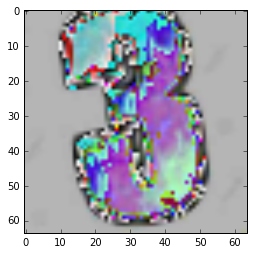

In [5]:
a, b = data.test.get_next_batch(1)
plt.imshow(a.reshape((64,64,3)))
plt.show()

In [6]:
# x and y coordinates to plot 
epochs = EPOCHS / STEPS_SIZE
x_coordinates = np.linspace(0, epochs, num=epochs)
loss_y_coordinates = np.zeros(epochs)
accuracy_y_coordinates = np.zeros(epochs)

def plot(x, y, limits, title, x_label_name, y_label_name):
    plt.close("all")
    figure = plt.figure()
    figure.clf()
    
    plt.plot(x, y)
    
    #plt.axis(limits)
    plt.ylabel(y_label_name)
    plt.xlabel(x_label_name)

    figure.suptitle(title, fontsize=20)
    plt.legend(loc='upper right')
    
    plt.show()
    return

def plot_loss():
    limits = [0,EPOCHS,0,5]
    plot(x_coordinates, loss_y_coordinates, limits, "Training Loss Overtime", "Epochs", "Loss")  
    return

def plot_accuracy():
    limits = [0,EPOCHS,0,1]
    plot(x_coordinates, accuracy_y_coordinates, limits, "Test Set Accuracy Overtime", "Epochs", "Accuracy")
    return

In [7]:
# Defining some functions that make the defining graph code look cleaner

def weight_variable(shape,name):
    gaussian_matrix = tf.truncated_normal(shape, stddev=0.1)
    weight_matrix = tf.Variable(gaussian_matrix, name=name)
    #weight_matrix = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(), shape=shape, name=name)
    return weight_matrix

def bias_variable(shape,name):
    gaussian_vector = tf.truncated_normal(shape, stddev=0.1)
    bias_vector = tf.Variable(gaussian_vector, name=name)
    #bias_vector = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(), shape=shape, name=name)
    return bias_vector

def convolution(images_matrix, weight_matrix):
    # [batch, height, width, depth]
    strides = [1,1,1,1]
    convoluted_images_matrix = tf.nn.conv2d(images_matrix, weight_matrix, strides=strides, padding='SAME')
    return convoluted_images_matrix

def max_pool_2x2(images_matrix):
    # [batch, height, width, depth]
    strides = [1,2,2,1]
    ksize = [1,2,2,1] #[1,2,2,1]
    smaller_images_matrix = tf.nn.max_pool(images_matrix, ksize=ksize, strides=strides, padding='SAME')
    return smaller_images_matrix

In [8]:
# Defining the graph (In this case it is convolutional neural network)

IMAGE_SIDE = 28 #64
DEPTH = 1 #3
CLASSES = 10 #4

NEURONS = 32

# inputs
targets_matrix = tf.placeholder(tf.float32, shape=[None, CLASSES], name="targets_matrix")
features_matrix = tf.placeholder(tf.float32, shape=[None, IMAGE_SIDE * IMAGE_SIDE * DEPTH], name='features_matrix') # 3072 784

# reshaping images as grids instead of vectors for convolution
# [rows, image_width, image_height, image_depth]
images_matrix = tf.reshape(features_matrix, [-1, IMAGE_SIDE, IMAGE_SIDE, DEPTH], name="input_node") # -1, 28, 28, 1



with tf.name_scope('convolutional1') as scope:
    # hidden inputs
    # [filter_width, filter_height, input_depth, num_filters]
    weight_matrix_conv1 = weight_variable([5, 5, DEPTH, NEURONS],name="weight_matrix_conv1")
    # one bias per filter [num_filters]
    bias_vector_conv1 = bias_variable([NEURONS], name="bias_vector_conv1")

    # linear operation
    linear_convoluted_matrix_conv1 = convolution(images_matrix, weight_matrix_conv1) + bias_vector_conv1

    # nonlinear operation
    nonlinear_convoluted_matrix_conv1 = tf.nn.relu(linear_convoluted_matrix_conv1)

    # making output smaller
    smaller_matrix_conv1 = max_pool_2x2(nonlinear_convoluted_matrix_conv1)



with tf.name_scope('convolutional2') as scope:
    # hidden inputs
    # [filter_width, filter_height, input_depth, num_filters]
    weight_matrix_conv2 = weight_variable([5, 5, NEURONS, NEURONS * 2], name="weight_matrix_conv2")
    # one bias per filter [num_filters]
    bias_vector_conv2 = bias_variable([NEURONS * 2], name="bias_vector_conv2")

    # linear operation
    linear_convoluted_matrix_conv2 = convolution(smaller_matrix_conv1, weight_matrix_conv2) + bias_vector_conv2

    # nonlinear operation
    nonlinear_convoluted_matrix_conv2 = tf.nn.relu(linear_convoluted_matrix_conv2)

    # making output smaller
    smaller_matrix_conv2 = max_pool_2x2(nonlinear_convoluted_matrix_conv2)

    # making output flat for fully connected layer
    # [rows, input_width * input_height * input_depth]
    smaller_matrix_conv2_flat = tf.reshape(smaller_matrix_conv2, [-1, (IMAGE_SIDE / 4) * (IMAGE_SIDE / 4) * (NEURONS * 2)]) #[-1, 7*7*64]



with tf.name_scope('fully_connected_hidden1') as scope:
    # hidden inputs
    # [input_width * input_height * input_depth, num_neuros]
    weight_matrix_fc1 = weight_variable([(IMAGE_SIDE / 4) * (IMAGE_SIDE / 4) * (NEURONS * 2), 2048], name="weight_matrix_fc1")
    # one bias per neuron [num_neurons]
    bias_vector_fc1 = bias_variable([2048], name="bias_vector_fc1")

    # linear operation
    linear_hidden_matrix_fc1 = tf.matmul(smaller_matrix_conv2_flat, weight_matrix_fc1) + bias_vector_fc1

    # nonlinear operation
    nonlinear_hidden_matrix_fc1 = tf.nn.relu(linear_hidden_matrix_fc1)



with tf.name_scope('fully_connected_output') as scope:
    # hidden inputs
    # [num_neurons, classes]
    weight_matrix_fc2 = weight_variable([2048, CLASSES], name="weight_matrix_fc2")
    # one bias per class [classes]
    bias_vector_fc2 = bias_variable([CLASSES], name="bias_vector_fc2")

    # linear operation
    output_matrix_fc2 = tf.matmul(nonlinear_hidden_matrix_fc1, weight_matrix_fc2) + bias_vector_fc2

    # making output probabilities
    probabilities_matrix = tf.nn.softmax(output_matrix_fc2, name = "output_node")


cross_entropy = tf.reduce_mean(-tf.reduce_sum(targets_matrix * tf.log(probabilities_matrix), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(probabilities_matrix,1), tf.argmax(targets_matrix,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
summaries = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter('./TensorBoard',graph=sess.graph)

In [10]:
# Initializing session and graph



# Training the convolutional neural network
step = 0

for epoch in range(EPOCHS):
    # This is my data
    #features, labels = data.train.get_next_batch(10)
    
    # This is mnist data
    batch = mnist.train.next_batch(40)
    features, labels = batch[0], batch[1]
    
    sess.run(train_step, feed_dict={features_matrix: features, targets_matrix: labels})
    
    if epoch % STEPS_SIZE == 0:
        l_scalar = sess.run(cross_entropy, feed_dict={features_matrix:features, targets_matrix: labels})
        a_scalar = sess.run(accuracy, feed_dict={features_matrix:features, targets_matrix: labels})
        loss_y_coordinates[step] = l_scalar
        accuracy_y_coordinates[step] = a_scalar
        step = step + 1

/home/isai/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


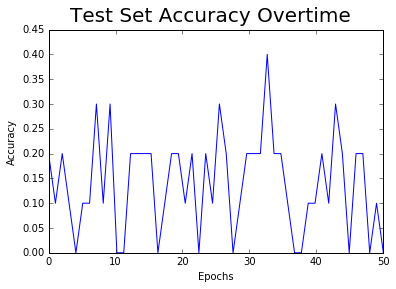

In [11]:
plot_accuracy()

In [12]:
mean_accuracy = np.mean(accuracy_y_coordinates)
print("Test Set Mean Accuracy")
print(mean_accuracy)

Test Set Mean Accuracy
0.140000002682


In [13]:
path = "./TrainedModel/"
checkpoint_weights_filename = "weights"
checkpoint_graph_filename = "graph.pb"
trained_graph_filename = "trained_graph.pb"

checkpoint_weights_path = path + checkpoint_weights_filename
checkpoint_graph_path = path + checkpoint_graph_filename
trained_graph_path = path + trained_graph_filename
saver_path = ""

as_text = True
as_binary = not as_text

# Saving learned weights of the model
tf.train.Saver().save(sess, checkpoint_weights_path) #, global_step=0, latest_filename="checkpoint_name")

# Saving graph definition
tf.train.write_graph(sess.graph.as_graph_def(), path, checkpoint_graph_filename, as_text)

# Merging graph definition and learned weights into a trained graph
input_saver_path = ""
input_binary = False
output_node_names = "output_node"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = False

freeze_graph (
    input_graph = checkpoint_graph_path,
    input_saver = saver_path,
    input_checkpoint = checkpoint_weights_path,
    output_graph = trained_graph_path,
    
    initializer_nodes = None, #"input_node",
    output_node_names = "fully_connected_output/output_node",
    
    restore_op_name = "save/restore_all",
    filename_tensor_name = "save/Const:0",
    
    input_binary = as_binary,
    clear_devices = True
)

Converted 8 variables to const ops.
35 ops in the final graph.
